<a href="https://colab.research.google.com/github/akshaya-nagarajan/DeepLearningProjects/blob/master/Project/DLProjectTransferLearningModelVGGModelMultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting the Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/Deep Learning project/"
image_dir = root_dir + 'Images/'

Mounted at /content/gdrive/


## To determine which version of TensorFlow being used

In [0]:
!pip show tensorflow

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorflow-estimator, gast, absl-py, keras-preprocessing, tensorboard, grpcio, google-pasta, wrapt, wheel, numpy, opt-einsum, h5py, protobuf, astunparse, scipy, termcolor, six
Required-by: fancyimpute


## Install required Libraries

In [0]:
import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
import time
import datetime

# Load the TensorBoard notebook extension
%load_ext tensorboard 

from glob import glob
import numpy as np
from numpy import expand_dims
import pandas as pd

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import os
from shutil import copy
from shutil import copytree, rmtree
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
# import tensorflow.compat.v1 as tf
# #To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
# tf.disable_eager_execution()

## Detect hardware and return appropriate distribution strategies

In [0]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## This is the TPU initialization code that has to be at the beginning.

In [0]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

## Displaying the Train Folder in the dataset

In [0]:
train_folders = glob(image_dir+'Split/Train/*')
# Lists all the folders in train set
train_folders

['/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/LowLunge',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/DownwardFacingDog',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/TreePose',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/WarriorPose',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/Planks',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/ReversePlanks',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/SidePlanks',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/SeatedForwardBend',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Train/TrianglePose']

## Displaying the Test Folder in the dataset

In [0]:
test_folders = glob(image_dir+'Split/Test/*')
# Lists all the folders in test set
test_folders

['/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/LowLunge',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/DownwardFacingDog',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/TreePose',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/WarriorPose',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/Planks',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/ReversePlanks',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/SidePlanks',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/SeatedForwardBend',
 '/content/gdrive/My Drive/Deep Learning project/Images/Split/Test/TrianglePose']

## Specifying the Train-Test paths 

In [0]:
# Actual train and test paths
train_path = image_dir+'Split/Train'
test_path = image_dir+'Split/Test'

## Creating a Mini Dataset for Testing Purposes and for other Multiple runs

In [0]:
def create_dataset_mini(img_list, source, destination):
  if os.path.exists(destination):
    # removing Mini dataset folder (if it already exists) folders, so that we will have only the classes that we want
    rmtree(destination) 
  # Make the destination directories
  os.makedirs(destination)
  # Iterate through each image specified in the image list and get all the images from that folder only
  
  for img_item in img_list :
    print("Copying images into",img_item)
    # Copy the images from source to destination
    copytree(os.path.join(source, img_item), os.path.join(destination, img_item))

## Specifying the folder names/path for mini dataset

In [0]:
# Specify the folders to create a Mini Dataset of
img_class_list = ['DownwardFacingDog','WarriorPose', 'ReversePlanks']

# Specify where to create the Mini Dataset in
train_path_mini = image_dir+'Split/mini'
test_path_mini = image_dir+'Split/mini'

## Below Commented out statements are one-time run. Each time a new folder will be created "replacing" the old one.

In [0]:
# print("Creating train data folder with new classes(specified in img_class_list)")
# create_dataset_mini(img_class_list, train_path, train_path_mini)

In [0]:
# print("Creating test data folder with new classes(specified in img_class_list)")
# create_dataset_mini(img_class_list, test_path, test_path_mini)

## Uncomment the below two lines if the mini dataset needs to be used

In [0]:
# # Reassigning the train and test paths specified previously
# train_path = train_path_mini
# test_path = test_path_mini

## List the Classes taken into consideration. The folder names were given in such a way that it'll be considered as Class names as well.

In [0]:
# List of classes Used'
classes = os.listdir(train_path)
classes

['LowLunge',
 'DownwardFacingDog',
 'TreePose',
 'WarriorPose',
 'Planks',
 'ReversePlanks',
 'SidePlanks',
 'SeatedForwardBend',
 'TrianglePose']

## Get all the image files in the Train dataset folder.

In [0]:
train_values = [] 
for c in classes:
    train_values.append(len(os.listdir(train_path+'/'+c)))

## Display the number of images available in each of the folders in Train Set

In [0]:
train_values

[1416, 901, 4022, 1077, 187, 508, 222, 1878, 2090]

## Indices to plot the graph

In [0]:
indexes = [0,1,2,3,4,5,6,7,8]
#indexes = [0, 1, 2]

## Distribution plot to visualize the number of images in each folder classes

Text(0.5, 1.0, 'Distribution of Classes in Training Set')

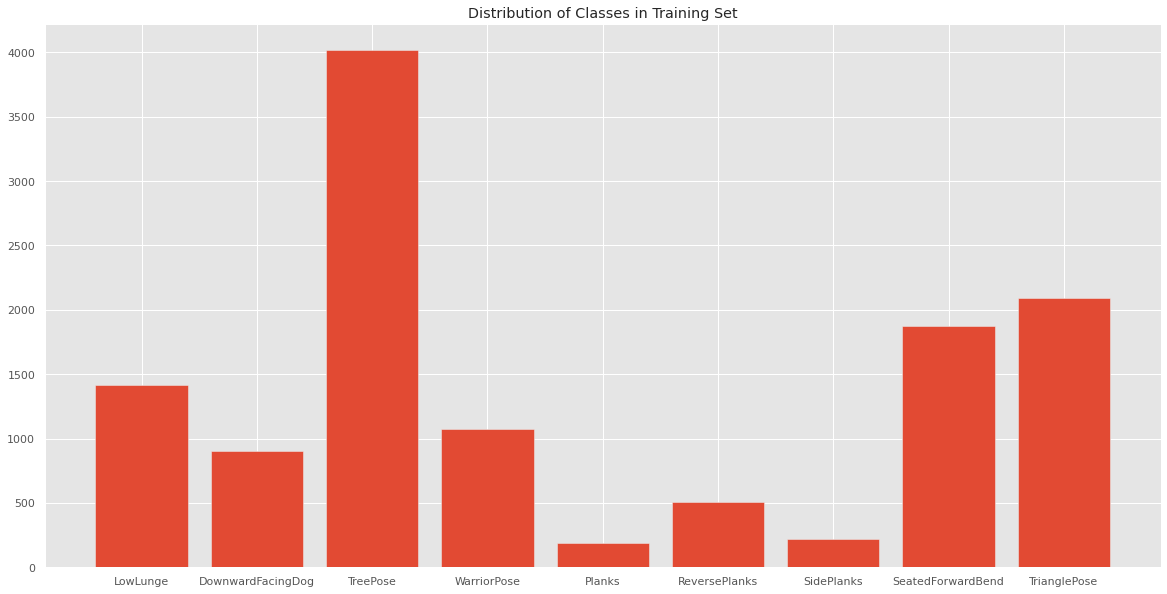

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
plt.bar(indexes,train_values)
plt.xticks(indexes,classes)
plt.title("Distribution of Classes in Training Set")

## Form Fields to input the model Parameters. Defualt values are set.

In [0]:
#@title Parameters for Models

#@markdown Enter the data to experiment with the model

#@markdown ---

image_width = 224 #@param {type:"integer"}

image_height = 224 #@param {type:"integer"}

epochs = 2 #@param {type:"slider", min:1, max:100, step:1}

batchSize = 32 #@param ["32", "64", "128", "256"] {type:"raw"}

fullConnectedLayer = 1024 #@param {type:"integer"}

LayersToFreeze = 10 #@param {type:"integer"}

#@markdown ---

## Model Parameters (Same like above)

In [0]:
# image_width, image_height = 224, 224 #fixed size 
# epochs = 3
# batchSize = 32ﬁ
# fullConnectedLayer = 1024
# LayersToFreeze = 10

## Get the file count from the directory

In [0]:
def get_files_count(directory):
  print('##### Getting the file Count #####')
  # If there're no folders in the specified directly, send the count as 0
  if not os.path.exists(directory):
    return 0
  count = 0

  # Else, walk through the directory to get the total count
  for val, dirs, files in os.walk(directory):
    for dir in dirs:
      count += len(glob(os.path.join(val, dir + "/*")))
  return count

In [0]:
def setupTransferLearn(model, base_model):
  print('##### Setting up the Transfer learning Model #####')
  # base model is VGG model
  # model is the additional Layers that was added
  for layer in base_model.layers:
    layer.trainable = False

  # Make all the layes in the VGG model as trainable False to Freeze the layers. It can not be changes further.
  # Compile the model.
  # Optimizer used: RMSProp,
  # Loss Calculated: categorical_crossentropy,
  # Accuracy metrics is measured.

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
def addAdditionalLayesToBaseModel(base_model, classes):
  print('##### Adding layers to the base model #####')
  ## Add additional last layers to the Base Model
  # base model is VGG model
  # classes: Total number of classes in consideration
  
  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  # Add a Fully Connected Layer, random init
  x = Dense(fullConnectedLayer, activation='relu')(x)

  # Add a Softmax Layer for predicting the output
  outputLayer = Dense(classes, activation='softmax')(x) 

  # Returns: New model with added last layers
  newModel = Model(base_model.input, outputLayer)
  return newModel

In [0]:
def changeLayerPropertyForFineTune(model):
  print('##### Freeze/UnFreeze the layers #####')
  # model: the Model that is used for training/testing
  ## Freeze the bottom LayersToFreeze and retrain the remaining top layers.
  ## LayersToFreeze corresponds to the top layers in the VGG Architecture

  for layer in model.layers[:LayersToFreeze]:
     layer.trainable = False

  for layer in model.layers[LayersToFreeze:]:
     layer.trainable = True

  # Compile the model.
  # Optimizer used: Stochastic gradient descent,
  # Learning rate and momentum
  # Loss Calculated: categorical_crossentropy,
  # Accuracy metrics is measured.
  
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
def transferLearningModel():
  print('##### Transfer Learning model to train on Yoga Dataset #####')

  ## Get the file count in the Train path
  totalTrainSamples = get_files_count(train_path)

  ## Total Classes taken
  totalClasses = len(glob(train_path+ "/*"))

  ## Get the file count in the Test/Validation path
  totalTestSamples = get_files_count(test_path)

  ## Type Conversion, just in case if the enter number in the form field is not of type int.
  epoch = int(epochs)

  ## Type Conversion, just in case if the enter number in the form field is not of type int.
  batch_size = int(batchSize)

  print('##### Data Augmentation #####')
  # Data Preparation for Train Set Using ImageDataGenerator
  train_datagenerator =  ImageDataGenerator(
      rescale = 1./255,
      preprocessing_function=preprocess_input,
      rotation_range = 30,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip=True
  )

  # Data Preparation for Validation Set Using ImageDataGenerator
  validation_datagenerator = ImageDataGenerator(
      rescale = 1./255,
      preprocessing_function = preprocess_input,
      rotation_range = 30,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True
  )

  ## Train set for the model
  train_generator = train_datagenerator.flow_from_directory(
    train_path,
    target_size = (image_width, image_height),
    batch_size = batch_size,
  )

  ## Validation set for the model
  validation_generator = validation_datagenerator.flow_from_directory(
    test_path,
    target_size = (image_width, image_height),
    batch_size = batch_size,
  )

  # Model Setup
  ## VGG 16 Model
  ## Input Shape is 224, 224, 3
  ## Getting the weights from pretrained model on Imagenet dataset
  ## include_top = False To exclude the final Fully Connected Layers

  print('##### Create Model #####')
  base_model = VGG16(input_shape = [image_width, image_height] + [3], weights='imagenet', include_top=False) 

  ## Save the inital model setup in base_model_vgg_initial.png file
  plot_model(base_model, to_file='base_model_vgg_initial.png', show_shapes=True)

  print('##### Add Layers in Model #####')
  ## Add bottom layers with output layer specific to the dataset under consideration
  model = addAdditionalLayesToBaseModel(base_model, totalClasses)

  ## Save the model setup after adding output layers in base_model_vgg_initial.png file
  plot_model(model, to_file='base_model_vgg_setup.png', show_shapes=True)

  ## Transfer Learning model setup
  setupTransferLearn(model, base_model)

  print('##### Model Summary #####')
  ## Print the Model Summary
  model.summary()
  
  ## TensorBoard Integration
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  
  ## History Object with model Accuracy and Loss values before fine tuning the model
  history_1 = model.fit_generator(
    train_generator,
    epochs=epoch,
    steps_per_epoch=totalTrainSamples,
    validation_data=validation_generator,
    validation_steps=totalTestSamples,
    callbacks=[tensorboard_callback])

  print('##### Plot Train and Validation Set - Accuracy and Loss Values Before Tuning #####')
  plot_training(history_1)
  
  # Fine Tune the Model by changing the Layer Trainable property
  changeLayerPropertyForFineTune(model)

  ## History Object with model Accuracy and Loss values After fine tuning the model
  history_2 = model.fit_generator(
    train_generator,
    steps_per_epoch=totalTrainSamples,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=totalTestSamples,
    callbacks=[tensorboard_callback])
  
  print('##### Plot Train and Validation Set - Accuracy and Loss Values After Tuning #####')
  plot_training(history_2)
  model.save('vggmodel.h5')
  ## Getting the file names from the validation set to get sample misclassified images
  fnames = validation_generator.filenames

  ## Actual classes
  actualClass = validation_generator.classes
  print('##### Actual Class #####', actualClass)

  ## Converting the Labels to Indices
  label2index = validation_generator.class_indices
  idx2label = dict((v,k) for k,v in label2index.items())

  ## To get the model Predictions based on Validation set
  predictions= model.predict_generator(validation_generator, steps = validation_generator.samples/validation_generator.batch_size, verbose=0)

  ## Predictions are in Float, Rounding them to get the actual classes
  predicted_classes = np.argmax(predictions,axis=1)
  ## print(predicted_classes)

  print('##### Some Misclassified classes #####')
  errors = np.where(predicted_classes != actualClass)[0]
  print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

  # for i in range(5):
  #   pred_class = np.argmax(predictions[errors[i]])
  #   pred_label = idx2label[pred_class]
  #   title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(fnames[errors[i]].split('/')[0], pred_label, predictions[errors[i]][pred_class])
  #   original = load_img('{}/{}'.format(test_path,fnames[errors[i]]))
  #   plt.figure(figsize=[7,7])
  #   plt.axis('off')
  #   plt.title(title)
  #   plt.imshow(original)
  #   plt.show()

  print('##### Class mapping to the Index #####')
  print(idx2label)

  print('##### Plotting Confusion Matrix #####')
  results = confusion_matrix(actualClass, predicted_classes) 
  #print(results)

  sns.set(font_scale=1.4) # for label size
  sns.heatmap(results, annot=True)
  plt.figure(figsize=(5,5))
  plt.show()

  print('##### Accuracy Score #####')
  print(accuracy_score(actualClass, predicted_classes))

  print('##### classification_report #####')
  print(classification_report(actualClass, predicted_classes))


In [0]:
def plot_training(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(accuracy))

  plt.plot(epochs, accuracy)
  plt.plot(epochs, val_accuracy, color='b')
  plt.title('Training and validation accuracy')
  plt.figure()
  
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss, color='b')
  plt.title('Training and validation loss')
  plt.show()

##### Transfer Learning model to train on Yoga Dataset #####
##### Getting the file Count #####
##### Getting the file Count #####
##### Data Augmentation #####
Found 12301 images belonging to 9 classes.
Found 1686 images belonging to 9 classes.
##### Create Model #####
##### Add Layers in Model #####
##### Adding layers to the base model #####
##### Setting up the Transfer learning Model #####
##### Model Summary #####
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (N

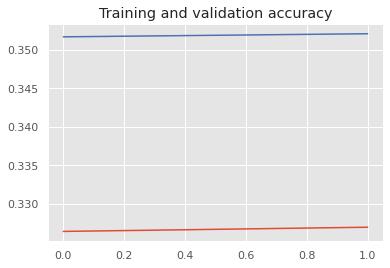

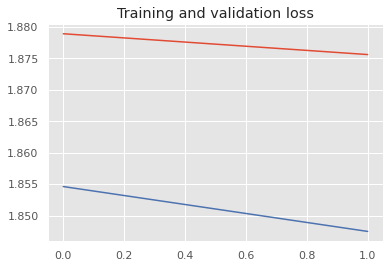

##### Freeze/UnFreeze the layers #####
Epoch 1/2
12301/12301 [==============================] - 7056s 574ms/step - loss: 1.8755 - accuracy: 0.3269 - val_loss: 1.8500 - val_accuracy: 0.3512
Epoch 2/2
12301/12301 [==============================] - ETA: 0s - loss: 1.8747 - accuracy: 0.3271

In [0]:
## To create and run the model in the specified device
with strategy.scope():
  transferLearningModel()

## Tensorboard Integration

In [0]:
%tensorboard --logdir logs/fit

In [0]:
!tensorboard dev upload --logdir ./logs \
  --name "VGG Model for Yoga Pose MultiClass Classification" \
  --description "Results from https://colab.research.google.com/drive/1oIKAn3leL7n6cryIJG7hjym5D0YdMt3n?usp=sharing"